# Projet Segmentation Clients

Dans le notebook précédent, nous avons identifié le nombre optimal de cluster sur notre jeu de donnée final et décrit les 4 segment client ainsi obtenu. 

Dans le but de déterminer la fréquence nécessaire de mise à jour du modèle de segmentation, nous allons étudier maintenant la stabilité de ces segments dans le temps.

In [1]:
# Librairies import
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns

from time import time
from dateutil.relativedelta import relativedelta

In [2]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.cluster import KMeans

A l'aide de la fonction ci-dessous, nous réaliserons toutes les procédures de nettoyage, de *feature engineering* et de *clustering* des notebooks précédents en fonction d'une période donnée (en mois).

In [3]:
def month_diff(cur_time, datetime_val): 
    return 12 * (cur_time.year - datetime_val.year) + (cur_time.month - datetime_val.month)

def periodic_dataset(period):
    start_time = time()
    print("Création du dataset ...")    
    
    ### Products & Categories_en
    products = pd.read_csv("archive/olist_products_dataset.csv")
    categories_en = pd.read_csv("archive/product_category_name_translation.csv")

    products = pd.merge(products, categories_en,
                        how="left",
                        on="product_category_name")

    products.drop(["product_category_name",
                   "product_weight_g",
                   "product_length_cm", 
                   "product_height_cm",
                   "product_width_cm",
                   "product_name_lenght",
                   "product_description_lenght",
                   "product_photos_qty"], axis=1, inplace=True)

    categ_name_replace = {"product_category_name_english": 
                                                      {"bed_bath_table": "C2", 
                                                       "housewares": "C2", 
                                                       "home_appliances": "C2",
                                                       "construction_tools_construction": "C2",
                                                       "home_construction": "C2",
                                                       "air_conditioning": "C2",
                                                       "home_confort": "C2",
                                                       "kitchen_dining_laundry_garden_furniture": "C2",
                                                       "home_appliances_2": "C2",
                                                       "furniture_bedroom": "C2",
                                                       "furniture_living_room": "C2"
                                                      }
                     }
    products = products.replace(categ_name_replace)
    products['product_category_name_english'] = np.where((products['product_category_name_english']\
                                                                      .str.contains("C2")==True),
                                                         'C2','C1')
    products = products.rename(columns={'product_category_name_english':'prod_categ'})


    ### Orders
    orders = pd.read_csv("archive/olist_orders_dataset.csv")    
    order_reviews = pd.read_csv("archive/olist_order_reviews_dataset.csv")
    order_items = pd.read_csv("archive/olist_order_items_dataset.csv")
    
    datetime_cols = ["order_purchase_timestamp", 
                     "order_delivered_customer_date",
                     "order_estimated_delivery_date"]
    
    for col in datetime_cols:
        orders[col] = orders[col].astype('datetime64[ns]')
    
    orders = orders[orders['order_status']=='delivered']
    
    orders.drop(['order_status',
                 'order_approved_at',
                 'order_delivered_carrier_date'], axis=1, inplace=True)
    
    order_reviews.drop(['review_id',
                    'review_comment_title',
                    'review_comment_message',
                    'review_creation_date',
                    'review_answer_timestamp'], axis=1, inplace=True)
    
    order_items.drop(['order_item_id',
                      'seller_id', 
                      'shipping_limit_date'], axis=1, inplace=True)


    orders = pd.merge(orders, order_reviews,
                       how="left",
                       on="order_id")
    
    orders = pd.merge(orders, order_items,
                       how="left",
                       on="order_id")

    
    # Select orders on period
    data_start = orders["order_purchase_timestamp"].min()
    data_stop  = data_start + relativedelta(months=period)
    
    print('data_start :=', data_start)
    print('data_stop :=', data_stop)
    
    data_max   = orders["order_purchase_timestamp"].max()
    if (data_stop > data_max ):
        print("date limite est dépassée")
        print('data_max :=',data_max)
        
        r = relativedelta(data_max, data_start)
        months_difference = (r.years * 12) + r.months
        print('donc period max :=', months_difference )        
        return
        
    orders = orders[(orders["order_purchase_timestamp"]>=data_start)
                              & (orders["order_purchase_timestamp"]<data_stop)]
    

    ### Customers
    customers = pd.read_csv("archive/olist_customers_dataset.csv")
    
    customers.drop(['customer_zip_code_prefix',
               'customer_city'], axis=1, inplace=True)
    
    ### Merge all
    data = pd.merge(orders, customers,
                how="left",
                on="customer_id")
    
    data = pd.merge(data, products,
                how="left",
                on="product_id")  
    
    data = data[~data[['order_delivered_customer_date']].isnull().any(axis=1)]
    
    # Imputation avec most_frequent
    missing_features = data.isnull().sum()
    missing_features = list(missing_features[missing_features.values > 0].index)
    for f in missing_features:
        data[f] = data[f].fillna(data[f].mean())
    
    ### Feature Engineering
    data_dumm = pd.get_dummies(data, columns=['prod_categ'])
    data_dumm = data_dumm.rename(columns={'prod_categ_C1':'C1',
                                      'prod_categ_C2': 'C2'})
    
    cur_time = data_dumm.order_purchase_timestamp.max() 
    data_dumm["delay_delivery"] = (data_dumm.order_delivered_customer_date
                               - data_dumm.order_purchase_timestamp).dt.round('1d').dt.days
    
    df = data_dumm.groupby("customer_unique_id").\
                    agg(nb_visits=("customer_id", "nunique"),
                        count_products=("product_id","count"),
                        total_price=("price", "sum"),
                        mean_price=("price","mean"),
                        total_freight=("freight_value","sum"),
                        mean_score=("review_score", "mean"),
                        mean_delivery_delay=("delay_delivery", "mean"),
                        total_C1=("C1", "sum"),
                        total_C2=("C2", "sum"),
                        first_purchase=('order_purchase_timestamp', 'min'), 
                        last_purchase=('order_purchase_timestamp', 'max'),
                        favorite_city=("customer_state", lambda x:x.value_counts().index[0])
                         )
    df = df.reset_index()
    
    df['cust_recency'] = df.last_purchase.apply(lambda x: month_diff(cur_time, x))
    
    df['cust_frequency'] = df.first_purchase.apply(lambda x: month_diff(cur_time, x))
    df['cust_frequency'] = np.round(df['cust_frequency'].div(df['nb_visits']))

    df['total_spend']   = (df.total_price + df.total_freight)
    df['cust_monetary'] = df['total_spend'].div(df['nb_visits'])
    
    df['ratio_C1'] = df['total_C1'].div(df['count_products'])
    df['ratio_C2'] = df['total_C2'].div(df['count_products'])
    
    df.drop(['mean_price',
#                      'last_purchase',
#                      'first_purchase',
                     'total_price',
                     'total_freight',
                     'total_spend',
                     'count_products',
                     'nb_visits',
                     'total_C1',
                     'total_C2',
                     'ratio_C2',
    ], axis=1, inplace=True)  
    
    end_time = time()
    
    print("Fin de création.. durée totale := {:.2f}s".format(end_time - start_time))
    
    return df

### Initialisation

On initialise avec une période initiale de 3 mois.

In [4]:
period   = 3
data_init = periodic_dataset(period=period)
print('init shape :=', data_init.shape)

Création du dataset ...
data_start := 2016-09-15 12:16:38
data_stop := 2016-12-15 12:16:38
Fin de création.. durée totale := 1.58s
init shape := (263, 10)


In [5]:
# Scaling

num_var = list(data_init.select_dtypes(include=['int64','float64']).columns)
X = data_init[num_var]    
X_scaled = MinMaxScaler().fit_transform(X)

# KMeans with best Kp

Kcluster = 4
km_model_init = KMeans(Kcluster)
km_model_init.fit(X_scaled)
km_labels_init = km_model_init.labels_

In [6]:
km_df_describe = {}

# On parcours l'ensemble du dataset avec une période de 4 mois
period_val = np.arange(period,23,4)

for p in period_val:
    print("___***"*10)
    print("now p :=", p)
    
    # Create dataset pour la periode p
    data_period = periodic_dataset(period=p)
    
    print('first pruchase :=',data_period.first_purchase.min())
    print('last purchase :=',data_period.last_purchase.max())
        
    # Scaling
    num_var  = list(data_period.select_dtypes(include=['int64','float64']).columns)
    X_per    = data_period[num_var] 
    
    # Clustering
    X_per_sc = MinMaxScaler().fit_transform(X_per)
    clust_X  = KMeans(Kcluster).fit(X_per_sc)
    
    data_period['kmeans_label'] = clust_X.labels_
    
    
    # On collecte les "dataframes_describe" pour chaque dataset pour l'identifiacation des clusters
    km_df_describe[p] = data_period.groupby("kmeans_label").describe()

___***___***___***___***___***___***___***___***___***___***
now p := 3
Création du dataset ...
data_start := 2016-09-15 12:16:38
data_stop := 2016-12-15 12:16:38
Fin de création.. durée totale := 1.65s
first pruchase := 2016-09-15 12:16:38
last purchase := 2016-10-10 18:09:39
___***___***___***___***___***___***___***___***___***___***
now p := 7
Création du dataset ...
data_start := 2016-09-15 12:16:38
data_stop := 2017-04-15 12:16:38
Fin de création.. durée totale := 3.03s
first pruchase := 2016-09-15 12:16:38
last purchase := 2017-04-15 12:12:15
___***___***___***___***___***___***___***___***___***___***
now p := 11
Création du dataset ...
data_start := 2016-09-15 12:16:38
data_stop := 2017-08-15 12:16:38
Fin de création.. durée totale := 6.55s
first pruchase := 2016-09-15 12:16:38
last purchase := 2017-08-15 12:15:23
___***___***___***___***___***___***___***___***___***___***
now p := 15
Création du dataset ...
data_start := 2016-09-15 12:16:38
data_stop := 2017-12-15 12:16:38
F

Comme l'algorithme `KMEANS` associe les labels des clusters à chaque étape de manière aléatoire, la fonctio ci-dessous permet de créer des listes qui permettra d'identifier le label des cluster à partir de ses caractéristiques.

In [7]:
def find_cluster_label(kmeans_df_describe, Kper_list):
    
    group0 = []
    group1 = []
    group2 = []
    group3 = []
    
    for k in np.arange(0,len(Kper_list)):
        p = Kper_list[k]
        df = kmeans_df_describe[p]

    # groupe 0 := Insatisfait
    # plus petit max_mean_score
        gr0 = df.iloc[:,df.columns.get_level_values(1)=='max']['mean_score'].idxmin().values[0]
        group0.append(gr0)
        
        df = df[~df.index.isin([gr0])]

    # groupe 1 := Très satisfait
    # plus grand min_mean_score
        gr1 = df.iloc[:,df.columns.get_level_values(1)=='min']['mean_score'].idxmax().values[0]
        group1.append(gr1)

        df = df[~df.index.isin([gr1])]

    # group 2 := Satisfait C2
        gr2 = df.iloc[:,df.columns.get_level_values(1)=='min']['ratio_C1'].idxmax().values[0]
        group2.append(gr2)

    # group 3 := Satisfait C1
        gr3 = df.iloc[:,df.columns.get_level_values(1)=='max']['ratio_C1'].idxmin().values[0]
        group3.append(gr3)            
        
    return group0, group1, group2, group3

In [8]:
gr0, gr1, gr2, gr3 = find_cluster_label(km_df_describe, period_val)

On utilise maintenant une représentation [Complex radar](https://gist.github.com/kylerbrown/29ce940165b22b8f25f4) pour représenter les évolutions temporelles des différents cluster sur un même graphique.

In [9]:
def _invert(x, limits):
    """inverts a value x on a scale from
    limits[0] to limits[1]"""
    return limits[1] - (x - limits[0])

def _scale_data(data, ranges):
    """scales data[1:] to ranges[0],
    inverts if the scale is reversed"""
    for d, (y1, y2) in zip(data[1:], ranges[1:]):
        assert (y1 <= d <= y2) or (y2 <= d <= y1)
    x1, x2 = ranges[0]
    d = data[0]
    if x1 > x2:
        d = _invert(d, (x1, x2))
        x1, x2 = x2, x1
    sdata = [d]
    for d, (y1, y2) in zip(data[1:], ranges[1:]):
        if y1 > y2:
            d = _invert(d, (y1, y2))
            y1, y2 = y2, y1
        sdata.append((d-y1) / (y2-y1) 
                     * (x2 - x1) + x1)
    return sdata

class ComplexRadar():
    def __init__(self, fig, variables, ranges,
                 n_ordinate_levels=6):
        angles = np.arange(0, 360, 360./len(variables))

        axes = [fig.add_axes([0.1,0.1,0.9,0.9],polar=True,
                label = "axes{}".format(i)) 
                for i in range(len(variables))]
        l, text = axes[0].set_thetagrids(angles, 
                                         labels=variables)
        [txt.set_rotation(angle-90) for txt, angle 
             in zip(text, angles)]
        for ax in axes[1:]:
            ax.patch.set_visible(False)
            ax.grid("off")
            ax.xaxis.set_visible(False)
        for i, ax in enumerate(axes):
            grid = np.linspace(*ranges[i], 
                               num=n_ordinate_levels)
            gridlabel = ["{}".format(round(x,2)) 
                         for x in grid]
            if ranges[i][0] > ranges[i][1]:
                grid = grid[::-1] # hack to invert grid
                          # gridlabels aren't reversed
            gridlabel[0] = "" # clean up origin
            ax.set_rgrids(grid, labels=gridlabel,
                         angle=angles[i])
            #ax.spines["polar"].set_visible(False)
            ax.set_ylim(*ranges[i])
        # variables for plotting
        self.angle = np.deg2rad(np.r_[angles, angles[0]])
        self.ranges = ranges
        self.ax = axes[0]
    def plot(self, data, lbl, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.plot(self.angle, np.r_[sdata, sdata[0]], label=lbl, *args, **kw)
        self.ax.legend()
    def fill(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.fill(self.angle, np.r_[sdata, sdata[0]], *args, **kw)

La fonction ci-dessous nous permet d'arranger les entrées pour pouvoir utiliser la *class Complex_Radar* précédente.

In [10]:
def cluster_radar_plot(kmeans_df_describe, Kper_list, max_Kper, grp_Kper, varLIST):
        
    # list des sous-kmean_df_describe
    grKper = {}
    for p in np.arange(0,max_Kper):
        temp = []
        for var in varLIST:
            temp.append(kmeans_df_describe[Kper_list[p]][var]['mean'].loc[grp_Kper[p]])
            grKper[p] = temp
        del temp
    
    # list des rangesMinMax
    rangeMinMax = []
    for var in varLIST:
        lMin = []
        lMax = []
        for p in np.arange(0,max_Kper):
            temp_mean = kmeans_df_describe[Kper_list[p]][var]['mean'].loc[grp_Kper[p]]
            temp_min  = temp_mean - 0.5*temp_mean
            temp_max  = temp_mean + 0.5*temp_mean
            lMin.append(temp_min)
            lMax.append(temp_max)
            del temp_mean, temp_min, temp_max
        rangeMinMax.append((min(lMin),max(lMax)))
        del lMin, lMax

    # On ajoute pour Count
    varLIST.append('Count')
    countMin = []
    countMax = []
    for p in np.arange(0,max_Kper):
        grKper[p].append(kmeans_df_describe[Kper_list[p]][varLIST[0]]['count'].loc[grp_Kper[p]])
        countMin.append(kmeans_df_describe[Kper_list[p]][varLIST[0]]['count'].loc[grp_Kper[p]])
        countMax.append(kmeans_df_describe[Kper_list[p]][varLIST[0]]['count'].loc[grp_Kper[p]])
    rangeMinMax.append((min(countMin),max(countMax)))
    
    # plotting
    fig = plt.figure(figsize=(8, 8))
    radar = ComplexRadar(fig, varLIST, rangeMinMax)
    colors = ['red','blue','green','black','magenta']
    for p in np.arange(0,max_Kper):
        radar.plot(grKper[p], 'per '+str(p), color=colors[p])
        radar.fill(grKper[p], alpha=0.02)
    plt.show()
    
    return fig

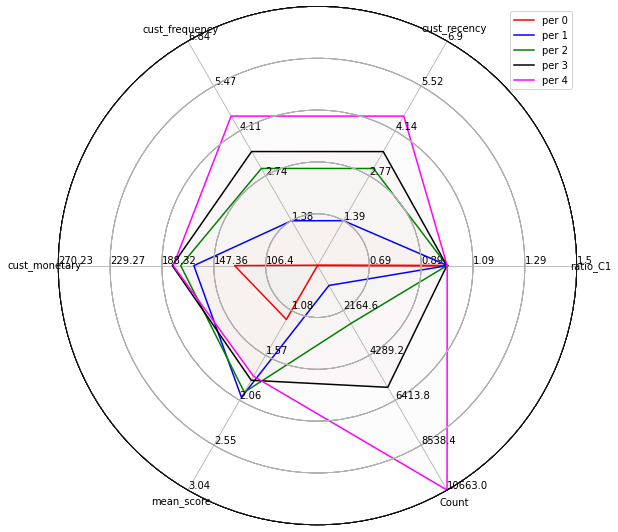

In [11]:
varALL = [
    'ratio_C1', 
           'cust_recency', 
           'cust_frequency', 
            'cust_monetary', 
           'mean_score', 
         ]
fig0 = cluster_radar_plot(km_df_describe, period_val, 5, gr0, varALL)

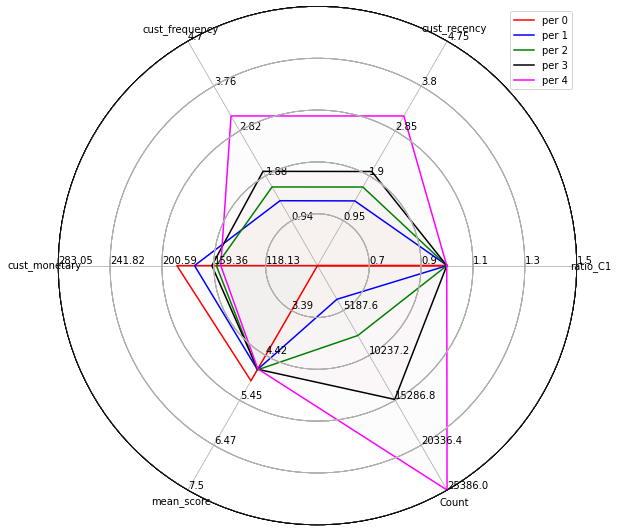

In [12]:
varALL = [
    'ratio_C1', 
           'cust_recency', 
           'cust_frequency', 
            'cust_monetary', 
           'mean_score', 
         ]

fig1 = cluster_radar_plot(km_df_describe, period_val, 5, gr1, varALL)

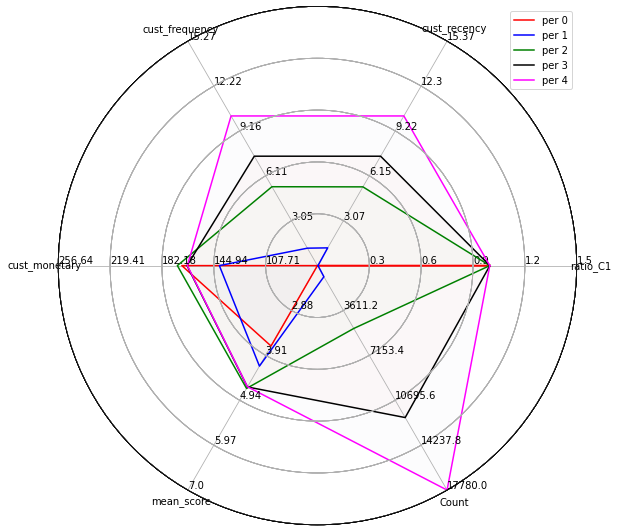

In [13]:
varALL = [
    'ratio_C1', 
           'cust_recency', 
           'cust_frequency', 
            'cust_monetary', 
           'mean_score', 
         ]

fig2 = cluster_radar_plot(km_df_describe, period_val, 5, gr2, varALL)

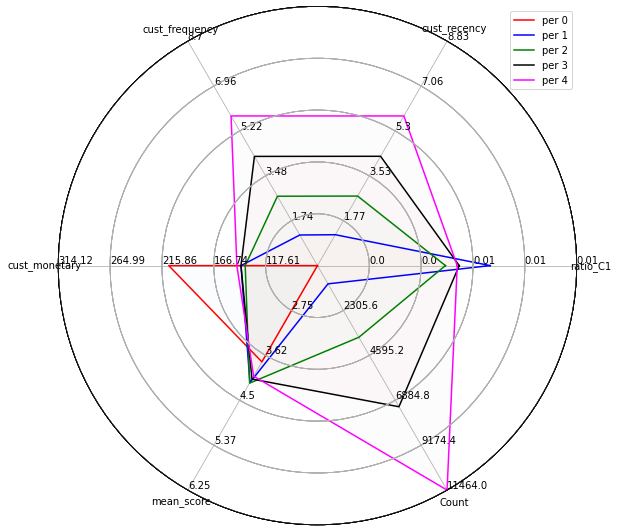

In [14]:
varALL = [
    'ratio_C1', 
           'cust_recency', 
           'cust_frequency', 
            'cust_monetary', 
           'mean_score', 
         ]

fig3 = cluster_radar_plot(km_df_describe, period_val, 5, gr3, varALL)

Ces quates clusters sont stables, et le nombre d'observations les constituants augementent ce qui implique que les segments n'ont pas tendance à disparaître. On peut alors mieux cibler les nouveaux clients qui feront parties de ces segments en utilisants des campagnes publicitaires adaptées. 